# Cube analysis with Gammapy (part 1)

## Introduction 

In order to run a cube likelihood analysis (combined spectrum and morphology fitting), we first have to prepare the dataset and compute the following inputs by stacking data from observation runs:
* counts, background and exposure cube
* mean PSF
* mean RMF

These are the inputs to the likelihood fitting step, where you assume a parameterised gamma-ray emission model and fit it to the stacked data.

This notebook is part 1 of 2 of a tutorial how to use [gammapy.cube](http://docs.gammapy.org/en/latest/cube/index.html) to do cube analysis of IACT data. Part 1 is about these pre-computations, part 2 will be about the likelihood fitting.

We will be using the following classes:
* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the data to stack in the cube
* [gammapy.image.SkyMask](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyMask.html) for computing the BKG model
* [gammapy.cube.SkyCube](http://docs.gammapy.org/en/latest/api/gammapy.cube.SkyCube.html) and [gammapy.cube.StackedObsCubeMaker](http://docs.gammapy.org/en/latest/api/gammapy.cube.StackedObsCubeMaker.html) to stack the data in the Cube
* [gammapy.data.ObservationList](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationList.html) to make the computation of the mean PSF and mean RMF from a set of runs.

The data used in this tutorial is 4 Crab runs from H.E.S.S..

## Setup

As always, we start with some setup for the notebook, and with imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

from gammapy.data import DataStore
from gammapy.image import SkyMask
from gammapy.cube import SkyCube, StackedObsCubeMaker

## Data preparation

Gammapy only supports binned likelihood fits, so we start by defining the spatial and energy grid of the data:

In [3]:
# define WCS specification
WCS_SPEC = {'nxpix': 50,
            'nypix': 50,
            'binsz': 0.05,
            'xref': 83.63,
            'yref': 22.01,
            'proj': 'TAN',
            'coordsys': 'CEL'}

# define reconstructed energy binning
ENERGY_SPEC = {'mode': 'edges',
               'enumbins': 5,
               'emin': 0.5,
               'emax': 40,
               'eunit': 'TeV'}

From this we create an empty `SkyCube` object, that we will use as reference for all other sky cube data:

In [4]:
# instanciate reference cube
REF_CUBE = SkyCube.empty(**WCS_SPEC, **ENERGY_SPEC)

Next we create a `DataStore` object, which allows us to access and load DL3 level data. In this case we will use four Crab runs of simulated HESS data, which is bundled in gammapy-extra:  

In [5]:
# setting up the data store
data_store = DataStore.from_dir("$GAMMAPY_EXTRA/test_datasets/cube/data")

# temporary fix for load psftable for one of the run that is not implemented yet...
data_store.hdu_table.remove_row(14)

For the later background estimation we define an exclusion mask. The background image will normalized on the counts map outside the exclusion region (the so called FOV background method). For convenience we use and all-sky exclusin mask, which was created from the TeVCat catalog and reproject it to our analysis region:

In [6]:
# read in TeVCat exclusion mask
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')

# reproject exclusion mask to reference cube
exclusion_mask = exclusion_mask.reproject(reference=REF_CUBE.sky_image_ref, order='nearest-neighbor')

That's what the exclusion mask looks like:

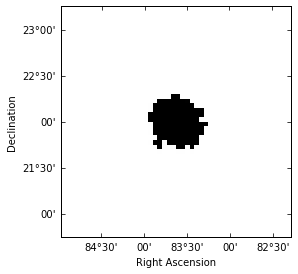

In [7]:
exclusion_mask.show()

Now we can feed all the input to the `StackedObsCubeMaker` class. In addition we have to select a offset cut:

In [8]:
#Select the offset band on which you want to select the events in the FOV of each observation
offset_band = Angle([0, 2.49], 'deg')

# instanciate StackedObsCubeMaker
cube_maker = StackedObsCubeMaker(
    empty_cube_images=REF_CUBE,
    empty_exposure_cube=REF_CUBE,
    offset_band=offset_band,
    data_store=data_store,
    obs_table=data_store.obs_table,
    exclusion_mask=exclusion_mask,
    save_bkg_scale=True,
)

We run the cube maker by calling `.make_cubes`. We pass an correlation radius of 4 pixels to compute the Li&Ma significance image:

In [9]:
# run cube maker
cube_maker.make_cubes(make_background_image=True, radius=4.)

Let's take a look at the computed result cubes:

In [10]:
# get counts cube
counts = cube_maker.counts_cube

energies = counts.energies(mode="edges")
print("Bin edges of the count cubes: \n{0}".format(energies))

Bin edges of the count cubes: 
[  0.5          1.20112443   2.88539981   6.93144843  16.65106415  40.        ] TeV


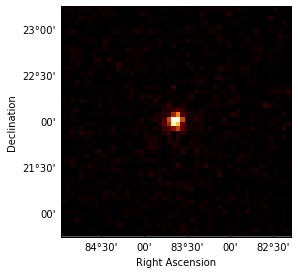

Energy range: 0.50 TeV to 1.20 TeV


In [11]:
# show counts image with idx = 0
idx = 0
counts.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

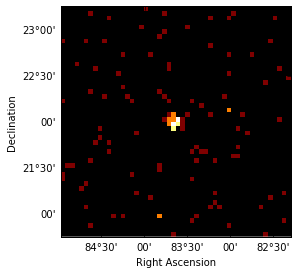

Energy range: 6.93 TeV to 16.65 TeV


In [12]:
idx = 3
counts.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

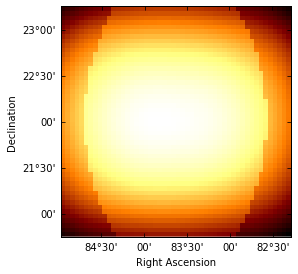

Energy range: 0.50 TeV to 1.20 TeV


In [13]:
background = cube_maker.bkg_cube

idx = 0
background.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

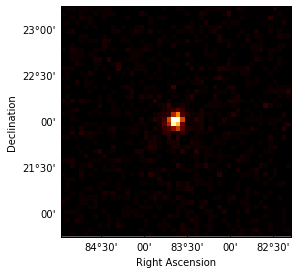

Energy range: 0.50 TeV to 1.20 TeV


In [14]:
excess = cube_maker.excess_cube

idx = 0
excess.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

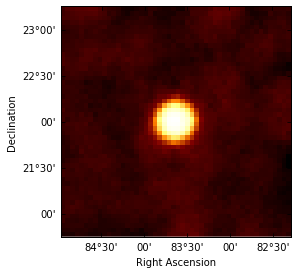

Energy range: 0.50 TeV to 1.20 TeV


In [15]:
significance = cube_maker.significance_cube

idx = 0
significance.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

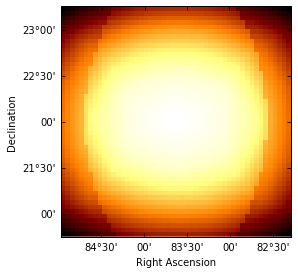

Energy range: 0.50 TeV to 1.20 TeV


In [16]:
exposure = cube_maker.exposure_cube

idx = 0
exposure.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

As a last step we'de like to compute a mean PSF across all observations in the list. For this purpose we use the `.make_mean_psf_cube()` method on the `StackedObsCubeMaker` object. We only have to specify a reference cube, which is used to evaluate the PSF model:

In [17]:
with np.errstate(divide='ignore', invalid='ignore'):
    mean_psf_cube = cube_maker.make_mean_psf_cube(REF_CUBE)

Let's take a quick look a the resulting PSF:

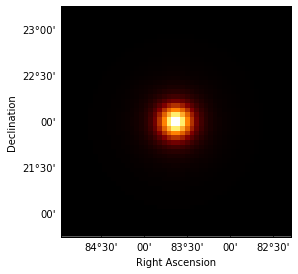

Energy range: 6.93 TeV to 16.65 TeV


In [18]:
idx = 3
psf_image = mean_psf_cube.sky_image_idx(idx=idx)
norm = psf_image.plot_norm(stretch='log')
psf_image.show(norm=norm)
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

Now we repeat the computation but assume a different energy binning for the "true" energy:

In [19]:
# define true energy binning
ENERGY_TRUE_SPEC = {'mode': 'edges',
                    'enumbins': 20,
                    'emin': 0.1,
                    'emax': 100,
                    'eunit': 'TeV'}

# init refereence cube
REF_CUBE_TRUE = SkyCube.empty(**WCS_SPEC, **ENERGY_TRUE_SPEC)

The reference cube is now passed to the `empty_exposure_cube` argument:

In [20]:
cube_maker = StackedObsCubeMaker(empty_cube_images=REF_CUBE,
                                 empty_exposure_cube=REF_CUBE_TRUE,
                                 offset_band=offset_band,
                                 data_store=data_store,
                                 obs_table=data_store.obs_table,
                                 exclusion_mask=exclusion_mask,
                                 save_bkg_scale=True)
cube_maker.make_cubes(make_background_image=True, radius=10.)

The PSF can computed using the "true" energy reference cube as well: 

In [21]:
with np.errstate(divide='ignore', invalid='ignore'):
    mean_psf_cube = cube_maker.make_mean_psf_cube(REF_CUBE_TRUE)

In [22]:
e_reco = cube_maker.counts_cube.energies(mode="edges")
print("Energy bin edges of the count cube: \n{}\n".format(e_reco))

e_true = cube_maker.exposure_cube.energies(mode="edges")
print("Energy bin edges of the exposure cube: \n{}".format(e_true))

Energy bin edges of the count cube: 
[  0.5          1.20112443   2.88539981   6.93144843  16.65106415  40.        ] TeV

Energy bin edges of the exposure cube: 
[  1.00000000e-01   1.41253754e-01   1.99526231e-01   2.81838293e-01
   3.98107171e-01   5.62341325e-01   7.94328235e-01   1.12201845e+00
   1.58489319e+00   2.23872114e+00   3.16227766e+00   4.46683592e+00
   6.30957344e+00   8.91250938e+00   1.25892541e+01   1.77827941e+01
   2.51188643e+01   3.54813389e+01   5.01187234e+01   7.07945784e+01
   1.00000000e+02] TeV


Finally we compute the mean RMF (energy dispersion matrix) across multiple observations:

In [23]:
# get reference energies
obs_list = data_store.obs_list(data_store.obs_table['OBS_ID'])
position = REF_CUBE.sky_image_ref.center
e_true = REF_CUBE_TRUE.energies('edges')
e_reco = REF_CUBE.energies('edges')

with np.errstate(divide='ignore', invalid='ignore'):
    mean_rmf = obs_list.make_mean_edisp(position=position, e_true=e_true, e_reco=e_reco)

/home/axel/Arbeit/Software/Anaconda/anaconda3.5/lib/python3.5/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


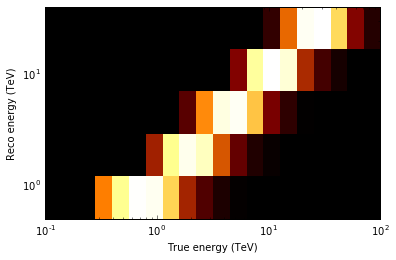

In [24]:
mean_rmf.plot_matrix()

## Exercises
- Take another dataset
- Change the Cube binning

Now that we created some cubes for counts, background, exposure, psf from a set of runs we will learn in the future tutorials how to use it for a 3D analysis (morphological and spectral)